___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Session - 10 Part -1<br><br>Univariate Time Series Forecasting with RNN<br><br>RSCCASN<br><h1>

# RNN (Time Series)

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [33]:
df = pd.read_csv('RSCCASN.csv',
                 index_col='DATE',
                 parse_dates=True
                )

# parse_dates almadan alsaydık 
# time series'lerde zaman feature'ını index'e alacağız.

In [34]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [36]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

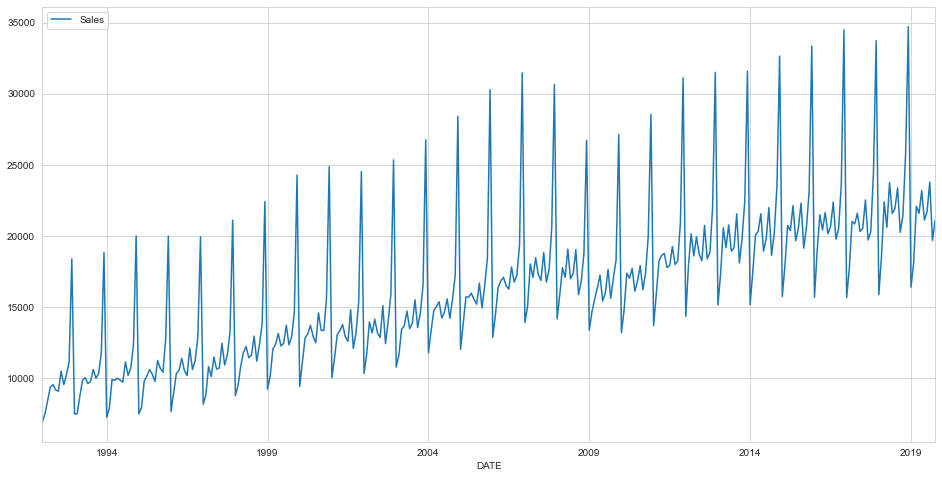

In [37]:
df.plot(figsize=(16,8))
# 2009'da kriz vardı mortgage krizi bu yüzden satışlar düşmüş.

## Preprocessing of Data

### Train Test Split

In [38]:
len(df)  # verimiz aylık olduğuna göre, benim periyodum 12. 12'de bir cycle döndürüyoruz.

334

In [39]:
test_size = 24 # test size'ını 24 satır ayarladık.

In [40]:
test_ind = len(df)- test_size
test_ind

310

In [41]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [42]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-06-01,20322
2017-07-01,20535
2017-08-01,22536


In [43]:
test

,Sales
DATE,
2017-11-01,24438
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919


### Scaling

In [44]:
from sklearn.preprocessing import MinMaxScaler

In [45]:
scaler = MinMaxScaler()

In [46]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [47]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [48]:
# help(TimeseriesGenerator)

In [49]:
length = 12
batch_size = 1 # batch_Size = 1 daha avantajlı küçük data setlerimizde
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)
# shuffle kısmı otomatik olaran False çünkü time series'lerde sıra önemli!! CNN'de mesela shuffle default olarak True.

In [50]:
len(generator)

298

In [51]:
generator[0]

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [52]:
X, y = generator[0]

In [53]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')
# 12 tane veriyoruz, 13. tahmin edecek.

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


## Modelling

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [55]:
n_features = train_scaled.shape[1]

In [56]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
# return_sequences=True niye koyduk? --> 
# 2 tane arka arkadaya RNN koyarsak bunu True dememiz lazım yoksa tek bir çıktı gönderir ve bu da anlamsız olur.
# Yani 2. layer da 1. layer gibi çalışsın diye.

return_sequences: Boolean. Whether to return the last output. in the output
    sequence, or the full sequence. Default: `False`.

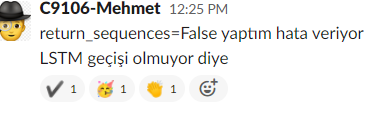

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 100)           40800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [58]:
# params = 4 * ((size_of_input + 1) * size_of_output + size_of_output^2)
4 * ((1+1)*100+(100**2))

40800

In [59]:
4 * ((100+1)*50+(50**2))

30200

### EarlyStopping and Validation Generator

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [62]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [63]:
len(validation_generator)

12

In [64]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
298/298 [==============================] - 7s 12ms/step - loss: 0.0216 - val_loss: 0.0271
Epoch 2/20
298/298 [==============================] - 3s 9ms/step - loss: 0.0179 - val_loss: 0.0355
Epoch 3/20
298/298 [==============================] - 3s 9ms/step - loss: 0.0168 - val_loss: 0.0234
Epoch 4/20
298/298 [==============================] - 3s 9ms/step - loss: 0.0174 - val_loss: 0.0238
Epoch 5/20
298/298 [==============================] - 3s 9ms/step - loss: 0.0175 - val_loss: 0.0230
Epoch 6/20
298/298 [==============================] - 3s 9ms/step - loss: 0.0150 - val_loss: 0.0215
Epoch 7/20
298/298 [==============================] - 3s 9ms/step - loss: 0.0149 - val_loss: 0.0302
Epoch 8/20
298/298 [==============================] - 3s 9ms/step - loss: 0.0165 - val_loss: 0.0233
Epoch 9/20
298/298 [==============================] - 3s 9ms/step - loss: 0.0126 - val_loss: 0.0203
Epoch 10/20
298/298 [==============================] - 3s 9ms/step - loss: 0.0122 - val_loss: 0.022

<AxesSubplot:>

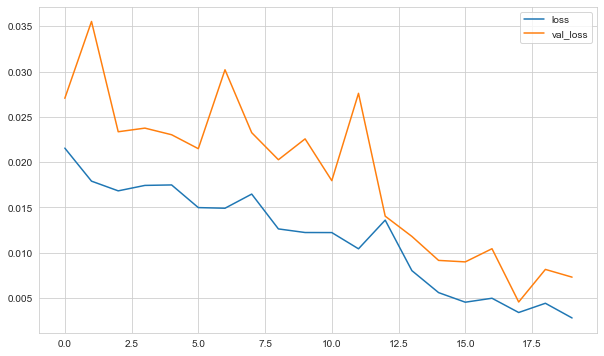

In [65]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()
# patlamalar olduğu için böyle oldu. Her bir patlamada datanın kendisini eğitmesi zor oluyor.
# bu yüzden de early stop uygulamamış mesela benim kodumda.
# Ağırlıkları farklı farklı atadığı için herkes farklı sonuçlar alıyor.

## Evaluate on Test Data

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [67]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [68]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
# CNN'de 3'ten 4'e çıkartıyor burda da 2'den 3'e çıkartıyor.
for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch) # burdaki 2 boyutlu array çıkıyor ama biz bunu tek boyutlu array yapmamız lazım
    
    # store prediction
    predictions_scaled.append(current_pred[0]) # işte burada yukardaki 2 boyutluyu 3 boyutluya çıkarttık
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1) # burada da 2 boyutluyu 3'e çıkarttık
# 


In [95]:
current_pred

array([[0.5336218]], dtype=float32)

In [96]:
current_batch

array([[[0.60960793],
        [0.64806867],
        [0.40052211],
        [0.46808478],
        [0.52811009],
        [0.52665019],
        [0.53850412],
        [0.51448345],
        [0.52932245],
        [0.53948367],
        [0.49399859],
        [0.53362179]]])

In [69]:
predictions_scaled

[array([0.5823076], dtype=float32),
 array([0.7924713], dtype=float32),
 array([0.35393655], dtype=float32),
 array([0.4159042], dtype=float32),
 array([0.48499852], dtype=float32),
 array([0.48213372], dtype=float32),
 array([0.4878579], dtype=float32),
 array([0.4581276], dtype=float32),
 array([0.46654603], dtype=float32),
 array([0.48403665], dtype=float32),
 array([0.4269113], dtype=float32),
 array([0.46085444], dtype=float32)]

In [70]:
eval_metrics(test_scaled[:length], predictions_scaled)
# test datamın sadece baştaki kısmıyla kıyaslayabilirin bu yüzden yukardaki kod.

r2_score: 0.664618002935945 
mae: 0.0725622955153914 
mse: 0.007427847775180175 
rmse: 0.0861849625815326


### Inverse Transformations and Comparing

In [71]:
predictions = scaler.inverse_transform(predictions_scaled)

In [72]:
compare = test[:12]

In [73]:
compare['Predictions'] = predictions

In [74]:
compare

,Sales,Predictions
DATE,,
2017-11-01,24438,22977.080
2017-12-01,33720,28765.829
2018-01-01,15881,16686.828
2018-02-01,18585,18393.665
2018-03-01,22404,20296.799
2018-04-01,20616,20217.891
2018-05-01,23764,20375.558
2018-06-01,21589,19556.666
2018-07-01,21919,19788.544


<AxesSubplot:xlabel='DATE'>

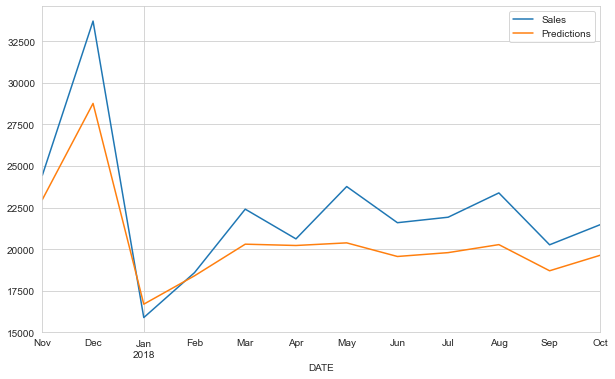

In [75]:
compare.plot()
# eh işte fena değil:))

In [76]:
eval_metrics(compare.Sales, compare.Predictions)

r2_score: 0.6646180029359443 
mae: 1998.6558676759432 
mse: 5635299.651909247 
rmse: 2373.8786093457365


## Retrain and Forecasting

In [77]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [78]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [79]:
len(df)

334

In [80]:
len(generator) # length'im 12 olduğu için 322

322

In [81]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
322/322 [==============================] - 7s 11ms/step - loss: 0.0257
Epoch 2/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0206
Epoch 3/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0210
Epoch 4/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0182
Epoch 5/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0174
Epoch 6/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0172
Epoch 7/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0166
Epoch 8/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0159
Epoch 9/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0150
Epoch 10/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0137
Epoch 11/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0125
Epoch 12/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0137
Epoch 13/15
322/322 

In [82]:
scaled_full_data.shape

(334, 1)

In [83]:
scaled_full_data[-length:].shape

(12, 1)

In [84]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [85]:
forecast = scaler.inverse_transform(forecast)

In [86]:
forecast # 12 aylık forecastlerimizz

array([[23729.04096031],
       [24788.40334892],
       [17969.98107624],
       [19830.92724538],
       [21484.26423407],
       [21444.05284309],
       [21770.55758286],
       [21108.93219757],
       [21517.65743589],
       [21797.53810787],
       [20544.69708395],
       [21636.07852936]])

In [87]:
df 

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [88]:
forecast_index = pd.date_range(start = '2019-11-01', periods = length, freq = 'MS')
# başlangıç zamanı veriyoruz ve ne kadarlık bir period boyunca bunu yapmak istediğimi yazıyoruz.

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

Bu yukardaki linkten ne vereceğimizi seçebiliriz

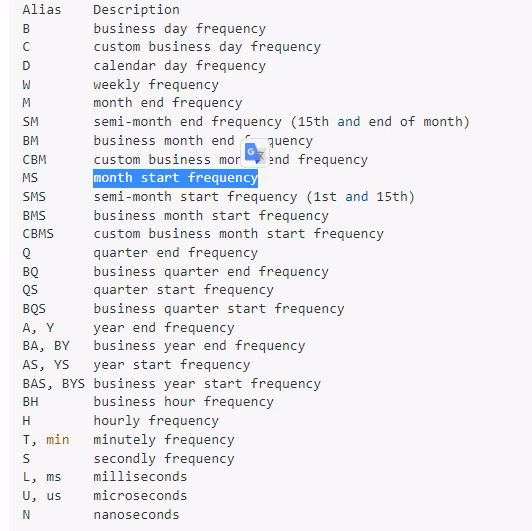

In [89]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [90]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [91]:
forecast_df

,Forecast
2019-11-01,23729.041
2019-12-01,24788.403
2020-01-01,17969.981
2020-02-01,19830.927
2020-03-01,21484.264
2020-04-01,21444.053
2020-05-01,21770.558
2020-06-01,21108.932
2020-07-01,21517.657
2020-08-01,21797.538


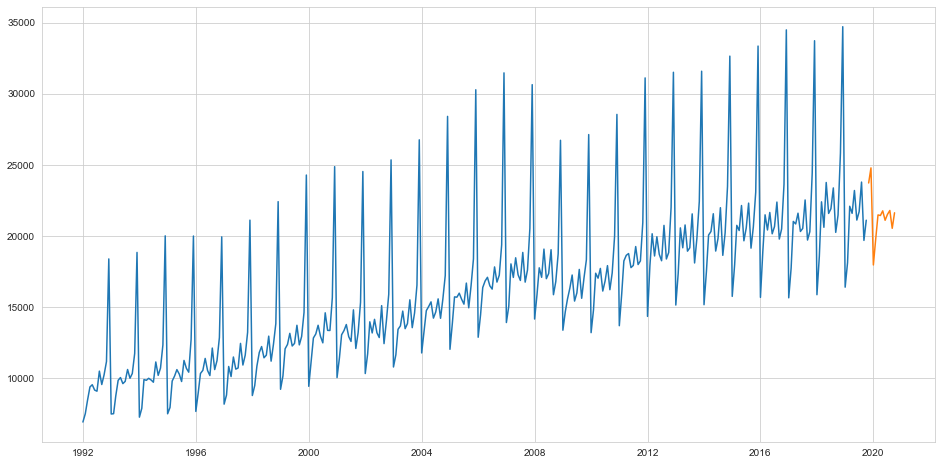

In [92]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast'])
# baya kötü bir forecast :((

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

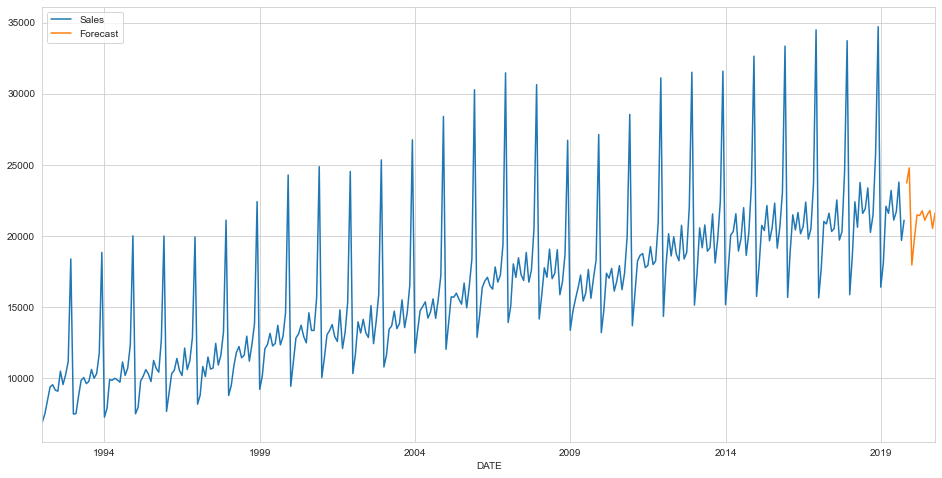

In [93]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

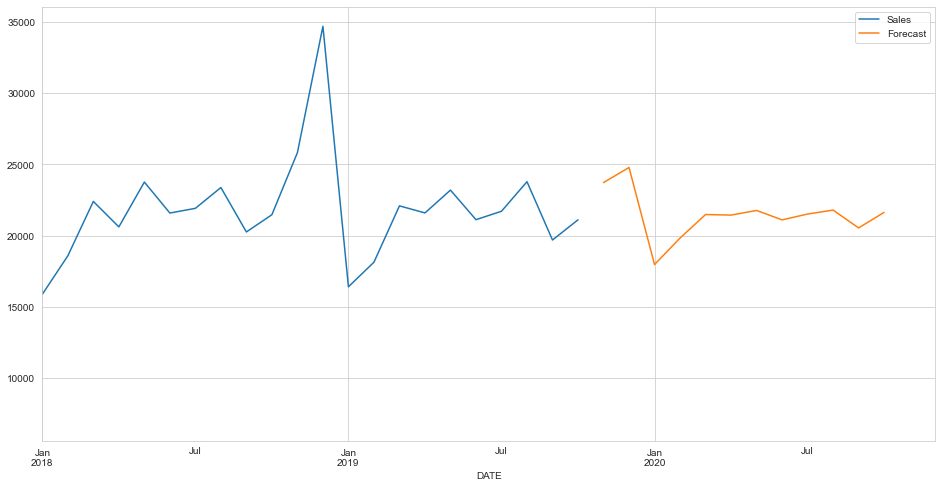

In [94]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')

Bu kopukluğun sebebi: iki ayrı plotumuz var, aynı dataframelerimizi plotlayabiliyor çünkü noktalar üzerinden line çizebiliyor
ama ayrı dataları plotlayamıyor. Ama aşağıda bunu gösterebiliriz istersek:

<AxesSubplot:>

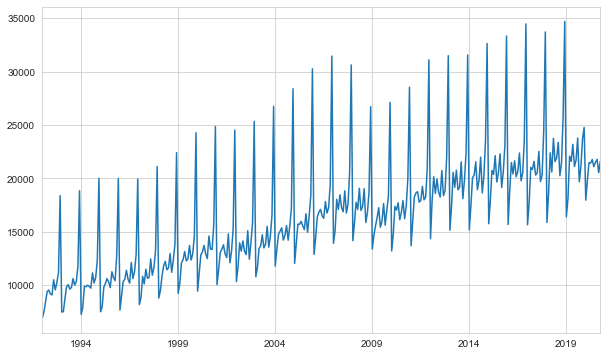

In [99]:
dataset_total = pd.concat((df['Sales'], forecast_df['Forecast']), axis=0)
dataset_total.plot()

Mesela burada birleştirip yaptık ama bu sefer de neresi gerçek data neresi forecast bunu göremiyoruz. Bu yüzden bunu tercih etmiyoruz.

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___